In [1]:
import pandas as pd 
import pandas as pd
import numpy as np
import pyeto
import model.integrated_model as model
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
future_data = pd.read_csv('../data/intermediate/predictions_linear_scaling.csv',index_col=0)

fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0)

mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0)

# 创建一个字典来存储观察数据
data_ssp245 = pd.DataFrame({
    'precip': fengqiao['precipitation'].combine_first(future_data['ssp585_pr']),
    'T2M': mete['T2M'].combine_first(future_data['ssp585_tas']),
    'T2M_MAX': mete['T2M_MAX'].combine_first(future_data['ssp585_tasmax']),
    'T2M_MIN': mete['T2M_MIN'].combine_first(future_data['ssp585_tasmin']),
})

data_ssp585 =pd.DataFrame({
    'precip': fengqiao['precipitation'].combine_first(future_data['ssp585_pr']),
    'T2M': mete['T2M'].combine_first(future_data['ssp245_tas']),
    'T2M_MAX': mete['T2M_MAX'].combine_first(future_data['ssp245_tasmax']),
    'T2M_MIN': mete['T2M_MIN'].combine_first(future_data['ssp245_tasmin']),
})

FileNotFoundError: [Errno 2] No such file or directory: '../data/intermediate/predictions_linear_scaling.csv'

# 蒸散发计算

In [72]:
def ETo_cal(tas,tasmax,tasmin):
    lat = pyeto.deg2rad(31.3)  # 转换纬度为弧度
    time_index = pd.to_datetime(tas.index)  # 创建一个时间索引

    sol_dec = np.array([pyeto.sol_dec(day) for day in time_index.dayofyear])
    sha = np.array([pyeto.sunset_hour_angle(lat, sd) for sd in sol_dec])
    ird = np.array([pyeto.inv_rel_dist_earth_sun(day) for day in time_index.dayofyear])
    et_rad = np.array([pyeto.et_rad(lat, sd, sh, ir) for sd, sh, ir in zip(sol_dec, sha, ird)])


    ETo = (pyeto.hargreaves(tasmin, tasmax, tas, et_rad)).round(2).interpolate()
    return ETo

In [73]:
data_ssp245['ETo_HS'] = ETo_cal(data_ssp245['T2M'],data_ssp245['T2M_MAX'],data_ssp245['T2M_MIN'])
data_ssp585['ETo_HS'] = ETo_cal(data_ssp585['T2M'],data_ssp585['T2M_MAX'],data_ssp585['T2M_MIN'])

# 水文模型

In [74]:
def calculate_runoff(precipitation,et):
    infiltration_rate= 0.0044493533287026255
    percolation_rate= 0.0015114617133019205
    baseflow_rate= 0.018787726309103157
    upper_zone_storage= 640.1599637595345
    lower_zone_storage= 0.0
    Area = 86.4

    params = [infiltration_rate, percolation_rate, baseflow_rate, upper_zone_storage, lower_zone_storage]
    runoff, _, _= model.integrated_model(params, precipitation, et,Area)

    return runoff

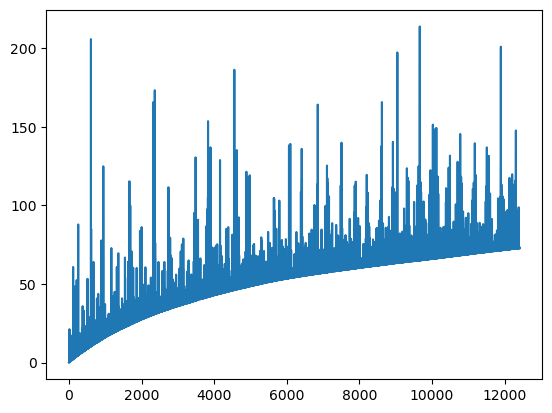

In [77]:
eto = ETo_cal(mete['T2M'],mete['T2M_MAX'],mete['T2M_MIN'])
test = calculate_runoff(fengqiao['precipitation'],data_ssp245['ETo_HS'])
plt.plot(test)

In [78]:
data_ssp245['runoff'] = calculate_runoff(data_ssp245['precip'],data_ssp245['ETo_HS'])
data_ssp585['runoff'] = calculate_runoff(data_ssp585['precip'],data_ssp585['ETo_HS'])

In [79]:
data_ssp245['runoff'].max() - data_ssp585['runoff'].max()

0.9500000000000455

# 机器学习

In [48]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_integrated_model.csv', index_col=0)
df = pd.DataFrame({
    'precip': fengqiao['precipitation'],
    'runoff': fengqiao['calculate_runoff'],
    'discharge': fengqiao['discharge'],
})
df.index = pd.to_datetime(df.index)

In [39]:
features = df.drop(['discharge'], axis=1)
target = df['discharge']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 98.6661334484312
R2 Score: 0.8160471215360882


In [41]:
pred_sspe245 = pd.DataFrame({
    'precip': data_ssp245['precip'],
    'runoff': data_ssp245['runoff'],
})

discharge_ssp245 = model.predict(pred_sspe245)

<Axes: >

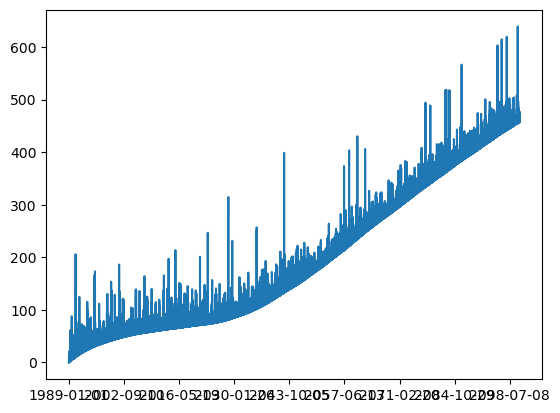

In [42]:
data_ssp245['runoff'].plot()

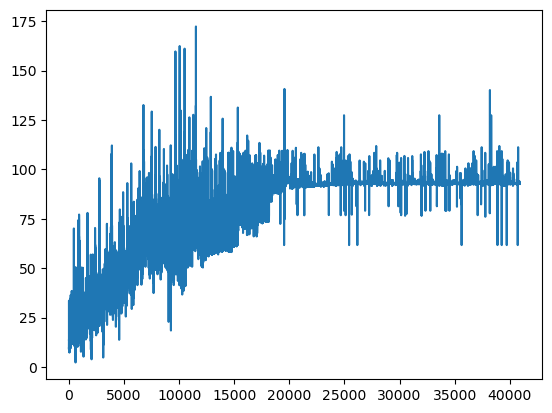

In [43]:
plt.plot(discharge_ssp245)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
X_train = data_ssp585.reindex(index=fengqiao.index)
y_train = fengqiao['discharge']

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [10]:
test = model.predict(data_ssp585)

<Axes: >

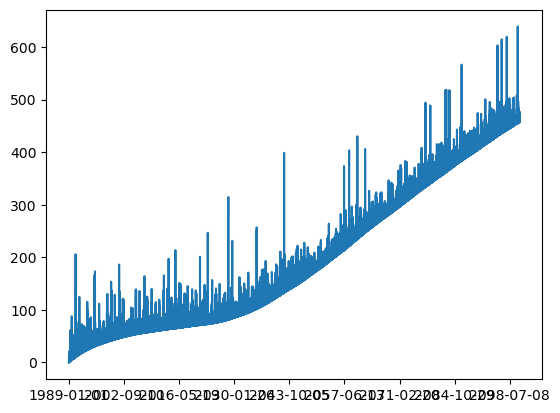

In [10]:
data_ssp245['runoff'].plot()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import statsmodels.api as sm

model_data = data_ssp245.reindex(index=fengqiao.index)

# 构建特征矩阵
features = pd.DataFrame({'precipitation': model_data['precip'], 'runoff': model_data['runoff'], 'ETo': model_data['ETo_HS'],'T2': model_data['T2M'],'T2_MAX': model_data['T2M_MAX'],'T2_MIN': model_data['T2M_MIN']})
# 添加常数列作为截距项
features = sm.add_constant(features)
# 拟合VAR模型
model = sm.OLS(fengqiao['discharge'], features)
results = model.fit()

In [28]:
y_pred = results.predict(features)

In [29]:
# 计算模型的性能指标（均方误差和R^2）
mse = mean_squared_error(fengqiao['discharge'], y_pred)
r2 = r2_score(fengqiao['discharge'], y_pred)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 170.66362501882355
R2 Score: 0.6691760381972127


In [56]:
test = data_ssp245.loc['2023-01-01':][['precip','runoff','ETo_HS','T2M','T2M_MAX','T2M_MIN']]

In [57]:
test = sm.add_constant(test)

In [58]:
test_r = results.predict(test)

<Axes: >

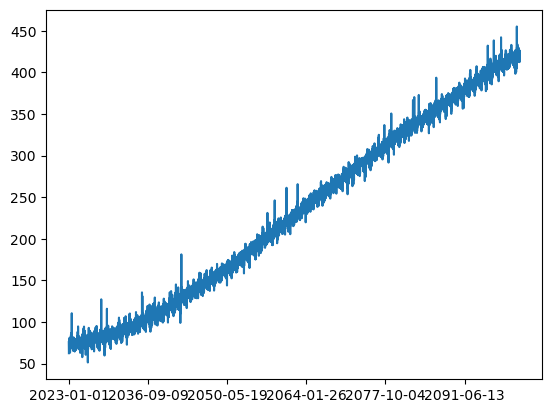

In [59]:
test_r.plot()

In [38]:
data_ssp585

,prcip,T2M,T2M_MAX,T2M_MIN,ETo_HS,runoff
1989-01-01,0.00,4.81,10.07,1.12,1.22,0.018179
1989-01-02,0.00,5.83,12.39,0.13,1.49,0.036330
1989-01-03,0.00,6.70,12.26,3.40,1.32,0.054453
1989-01-04,0.00,7.05,12.15,4.04,1.29,0.072550
1989-01-05,0.90,7.32,12.61,3.19,1.41,0.090644
...,...,...,...,...,...,...
2100-12-26,0.00,14.45,17.88,8.40,1.77,457.217014
2100-12-27,0.00,16.07,19.46,10.67,1.79,457.229109
2100-12-28,0.06,7.71,13.13,2.36,1.49,457.241187
2100-12-29,0.00,3.22,8.21,-1.16,1.15,457.253247


<Axes: >

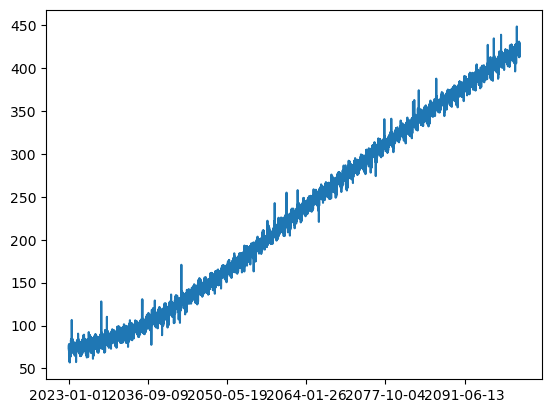

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import statsmodels.api as sm

model_data = data_ssp585.reindex(index=fengqiao.index)

# 构建特征矩阵
features = pd.DataFrame({'precipitation': model_data['precip'], 'runoff': model_data['runoff'], 'ETo': model_data['ETo_HS'],'T2': model_data['T2M'],'T2_MAX': model_data['T2M_MAX'],'T2_MIN': model_data['T2M_MIN']})
# 添加常数列作为截距项
features = sm.add_constant(features)
# 拟合VAR模型
model = sm.OLS(fengqiao['discharge'], features)
results = model.fit()

test = data_ssp585.loc['2023-01-01':][['precip','runoff','ETo_HS','T2M','T2M_MAX','T2M_MIN']]

test = sm.add_constant(test)

test_r_585 = results.predict(test)

test_r_585.plot()

<Axes: >

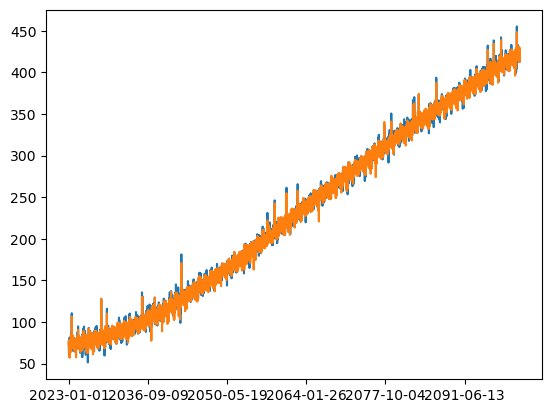

In [60]:
test_r.plot()
test_r_585.plot()

In [76]:
with open('model/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [54]:
desired_order = ['precip', 'runoff', 'T2M_MAX', 'T2M_MIN', 'T2M', 'ETo_HS']
data_ssp245 = data_ssp245.reindex(columns=desired_order).loc['2023-01-01':'2050-12-31']
data_ssp245.head()

,precip,runoff,T2M_MAX,T2M_MIN,T2M,ETo_HS
2023-01-01,0.00,72.734573,11.03,-2.08,3.17,1.37
2023-01-02,23.10,93.765657,13.32,0.95,9.05,1.71
2023-01-03,0.04,72.739202,13.28,4.25,8.34,1.42
2023-01-04,0.45,72.741522,8.03,4.25,5.92,0.84
2023-01-05,1.16,72.743849,8.30,3.11,5.47,0.97


In [73]:
desired_order = ['precip', 'runoff', 'T2M_MAX', 'T2M_MIN', 'T2M', 'ETo_HS']
data_ssp245_test = data_ssp245.reindex(columns=desired_order).loc['2022-12-31':'2050-12-31']
data_ssp245_test.head()

,precip,runoff,T2M_MAX,T2M_MIN,T2M,ETo_HS
2022-12-31,0.00,72.732264,9.94,-0.44,4.19,1.27
2023-01-01,0.00,72.734573,11.03,-2.08,3.17,1.37
2023-01-02,23.10,93.765657,13.32,0.95,9.05,1.71
2023-01-03,0.04,72.739202,13.28,4.25,8.34,1.42
2023-01-04,0.45,72.741522,8.03,4.25,5.92,0.84


In [74]:
test = rf_model.predict(data_ssp245_test)

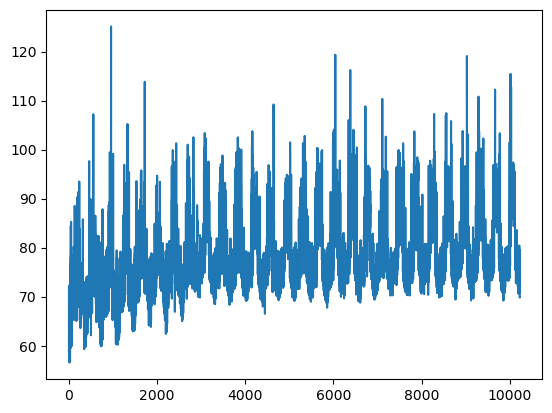

In [75]:
plt.plot(test)

In [52]:
data_ssp245['discharge'] = rf_model.predict(data_ssp245)

<Axes: >

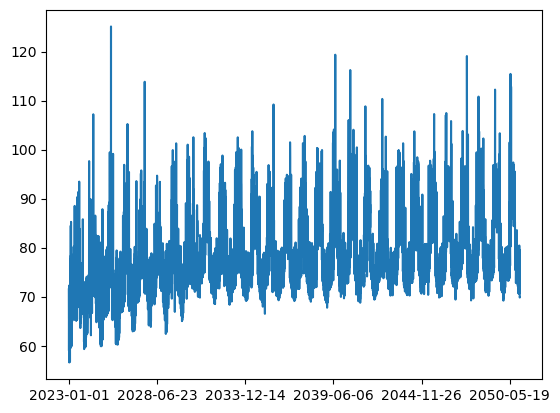

In [53]:
data_ssp245['discharge'].plot()

In [7]:
with open('model/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

X_ssp245 = pd.DataFrame({
    'precip': future_data.ssp245_pr,
    'runoff': future_data.ssp245_runoff_integrated_model,
    'T2M_MAX': future_data.ssp245_tasmax,
    'T2M_MIN': future_data.ssp245_tasmin,
    'T2M': future_data.ssp245_tas,
    'ETo_HS': future_data.ssp245_ETo
})
X_ssp245.index = pd.to_datetime(X_ssp245.index)

X_ssp585 = pd.DataFrame({
    'precip': future_data.ssp585_pr,
    'runoff': future_data.ssp585_runoff_integrated_model,
    'T2M_MAX': future_data.ssp585_tasmax,
    'T2M_MIN': future_data.ssp585_tasmin,
    'T2M': future_data.ssp585_tas,
    'ETo_HS': future_data.ssp585_ETo
})
X_ssp585.index = pd.to_datetime(X_ssp585.index)

In [8]:
future_data['ssp245_discharge'] = rf_model.predict(X_ssp245)
future_data['ssp585_discharge'] = rf_model.predict(X_ssp585)

future_data = future_data.loc['2024-01-01':]

In [54]:
plt.plot(future_data.index,future_data['discharge_ssp245'],label='ssp245')
plt.plot(future_data.index,future_data['discharge_ssp585'],label='ssp585')
plt.legend()
plt.show()

KeyboardInterrupt: 

# 流量水位关系

In [61]:
data_ssp245['discharge'] = test_r
data_ssp585['discharge'] = test_r_585

In [69]:
data_ssp245

,precip,T2M,T2M_MAX,T2M_MIN,ETo_HS,runoff,discharge,date,days_since_start,wl
2023-01-01,0.00,3.17,11.03,-2.08,1.37,72.734573,62.508184,2023-01-01,0,4.0404
2023-01-02,23.10,9.05,13.32,0.95,1.71,93.765657,76.971487,2023-01-02,1,4.1651
2023-01-03,0.04,8.34,13.28,4.25,1.42,72.739202,71.275225,2023-01-03,2,4.1875
2023-01-04,0.45,5.92,8.03,4.25,0.84,72.741522,75.690495,2023-01-04,3,4.1605
2023-01-05,1.16,5.47,8.30,3.11,0.97,72.743849,73.487752,2023-01-05,4,4.1894
...,...,...,...,...,...,...,...,...,...,...
2100-12-26,0.00,5.46,11.81,0.21,1.41,457.217014,416.073704,2100-12-26,28483,4.4057
2100-12-27,0.00,5.39,11.34,1.19,1.32,457.229109,416.601905,2100-12-27,28484,4.4057
2100-12-28,0.06,6.23,10.03,1.85,1.23,457.241187,422.070032,2100-12-28,28485,4.4057
2100-12-29,0.00,3.52,10.44,-2.72,1.38,457.253247,414.251550,2100-12-29,28486,4.4057


In [67]:
from joblib import load
rating_curve_model = load('../data/intermediate/random_forest_model.joblib')
data_ssp245 = data_ssp245.loc['2023-01-01':]
data_ssp245.loc[:, 'date'] = pd.to_datetime(data_ssp245.index)
data_ssp245.loc[:, 'days_since_start'] = (data_ssp245['date'] - data_ssp245['date'].iloc[0]).dt.days

X_ssp245_wl = data_ssp245[['discharge', 'days_since_start']]
data_ssp245.loc[:, 'wl'] = rating_curve_model.predict(X_ssp245_wl)

/tmp/ipykernel_310552/3903152591.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_ssp245.loc[:, 'date'] = pd.to_datetime(data_ssp245.index)


<Axes: >

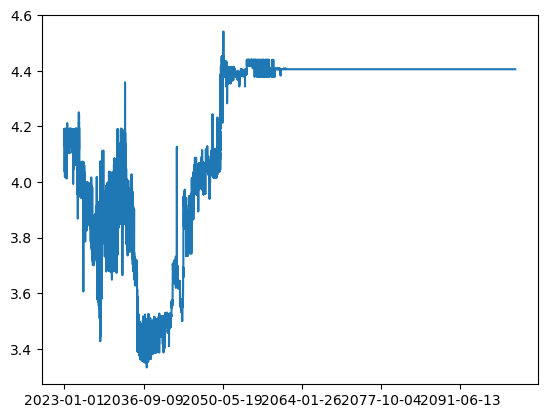

In [68]:
data_ssp245.loc[:, 'wl'].plot()

In [3]:
from joblib import load
rating_curve_model = load('../data/intermediate/random_forest_model.joblib')

future_data['date'] = pd.to_datetime(future_data.index)
future_data['days_since_start'] = (future_data['date'] - future_data['date'].min()).dt.days
X_ssp245_wl = future_data[['ssp245_discharge','days_since_start']]
X_ssp245_wl = X_ssp245_wl.rename(columns={'ssp245_discharge': 'discharge'})
future_data['ssp245_wl'] = rating_curve_model.predict(X_ssp245_wl)

X_ssp585_wl = future_data[['ssp585_discharge','days_since_start']]
X_ssp585_wl = X_ssp585_wl.rename(columns={'ssp585_discharge': 'discharge'})
future_data['ssp585_wl'] = rating_curve_model.predict(X_ssp585_wl)

NameError: name 'future_data' is not defined

In [11]:
future_data.head()

,ssp245_pr,ssp245_ps,ssp245_tas,ssp245_tasmax,ssp245_tasmin,ssp585_pr,ssp585_ps,ssp585_tas,ssp585_tasmax,ssp585_tasmin,ssp245_ETo,ssp585_ETo,ssp245_runoff_integrated_model,ssp585_runoff_integrated_model,ssp245_discharge,ssp585_discharge,date,days_since_start,ssp245_wl,ssp585_wl
2024-01-01,1.3,101.50,6.66,6.30,-2.28,0.00,102.69,3.12,12.51,-1.13,1.29,1.39,274.255823,275.357790,75.473,73.093,2024-01-01,0,4.1605,4.1894
2024-01-02,2.4,101.30,4.39,7.10,1.11,0.00,101.51,5.91,10.35,-3.52,0.98,1.60,274.966585,276.104788,75.486,73.205,2024-01-02,1,4.1605,4.1894
2024-01-03,0.0,102.21,13.93,12.87,3.76,2.35,102.30,2.17,10.79,7.39,1.74,0.67,275.676272,276.853506,73.720,74.303,2024-01-03,2,4.1894,4.1850
2024-01-04,0.0,102.97,-0.56,16.25,0.20,2.35,101.70,-0.14,7.50,-1.81,1.26,0.98,276.384887,277.603943,70.985,73.027,2024-01-04,3,4.1875,4.1894
2024-01-05,0.0,101.81,6.56,12.23,-4.67,2.35,102.23,4.81,3.85,-3.99,1.83,1.15,277.092430,278.356096,74.022,74.523,2024-01-05,4,4.1894,4.1850


In [15]:
ssp245 = future_data[['ssp245_pr','ssp245_tasmax','ssp245_tasmin','ssp245_tas','ssp245_ETo','ssp245_discharge','ssp245_wl']]
ssp585 = future_data[['ssp585_pr','ssp585_tasmax','ssp585_tasmin','ssp585_tas','ssp585_ETo','ssp585_discharge','ssp585_wl']]

ssp245.to_csv('../data/intermediate/ssp245.csv')
ssp585.to_csv('../data/intermediate/ssp585.csv')

Mean Squared Error: 2868.380104023342
R2 Score: -4.560229192744676


<Axes: >

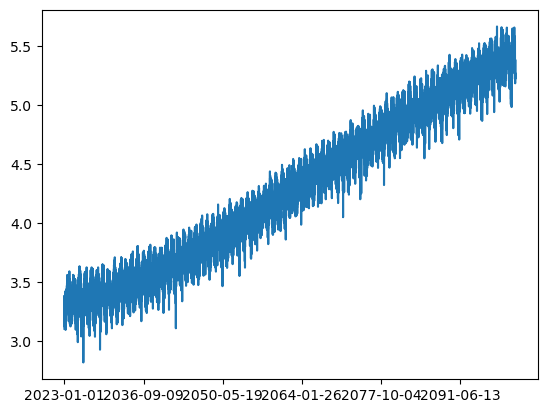

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import statsmodels.api as sm

train_data = data_ssp245.reindex(index=fengqiao.index)

# 构建特征矩阵
features = pd.DataFrame({'precipitation': train_data['precip'], 'runoff': train_data['runoff'], 'ETo': train_data['ETo_HS'],'T2': train_data['T2M'],'T2_MAX': train_data['T2M_MAX'],'T2_MIN': train_data['T2M_MIN']})
# 添加常数列作为截距项
features = sm.add_constant(features)
# 拟合VAR模型
model = sm.OLS(fengqiao['water_level'], features)
results = model.fit()

y_pred = results.predict(features)
# 计算模型的性能指标（均方误差和R^2）
mse = mean_squared_error(fengqiao['discharge'], y_pred)
r2 = r2_score(fengqiao['discharge'], y_pred)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

features_ssp245 = data_ssp245.loc['2023-01-01':][['precip','runoff','ETo_HS','T2M','T2M_MAX','T2M_MIN']]

features_ssp245 = sm.add_constant(features_ssp245)

wl_ssp_245 = results.predict(features_ssp245)

wl_ssp_245.plot()

In [81]:
wl_ssp_245.max()

5.667205541969722

In [82]:
fengqiao['water_level'].max()

4.67

Mean Squared Error: 2868.380104023342
R2 Score: -4.560229192744676


<Axes: >

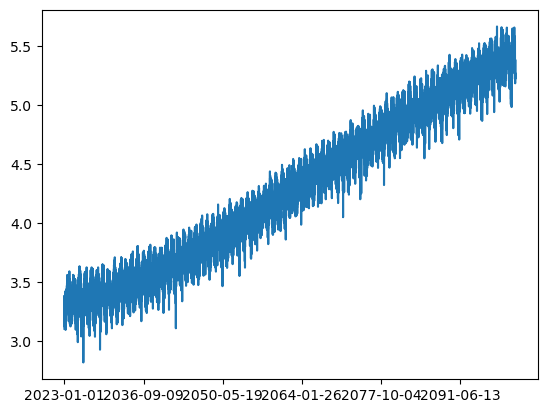

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import statsmodels.api as sm

train_data = data_ssp585.reindex(index=fengqiao.index)

# 构建特征矩阵
features = pd.DataFrame({'precipitation': train_data['precip'], 'runoff': train_data['runoff'], 'ETo': train_data['ETo_HS'],'T2': train_data['T2M'],'T2_MAX': train_data['T2M_MAX'],'T2_MIN': train_data['T2M_MIN']})
# 添加常数列作为截距项
features = sm.add_constant(features)
# 拟合VAR模型
model = sm.OLS(fengqiao['water_level'], features)
results = model.fit()

y_pred = results.predict(features)
# 计算模型的性能指标（均方误差和R^2）
mse = mean_squared_error(fengqiao['discharge'], y_pred)
r2 = r2_score(fengqiao['discharge'], y_pred)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

features_ssp585 = data_ssp585.loc['2023-01-01':][['precip','runoff','ETo_HS','T2M','T2M_MAX','T2M_MIN']]

features_ssp585 = sm.add_constant(features_ssp245)

wl_ssp_585 = results.predict(features_ssp245)

wl_ssp_585.plot()

In [84]:
wl_ssp_585.max()

5.667205541969722

Mean Squared Error: 2868.380104023342
R2 Score: -4.560229192744676


<Axes: >

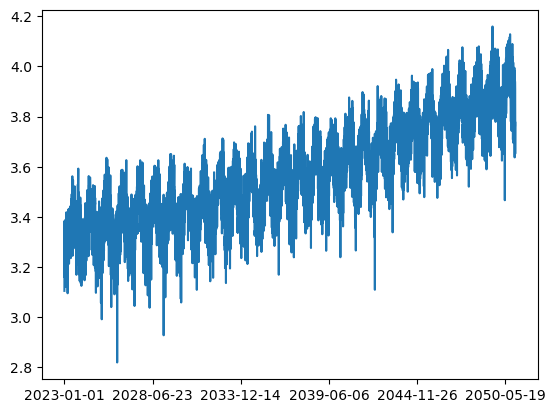

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import statsmodels.api as sm

train_data = data_ssp245.reindex(index=fengqiao.index)

# 构建特征矩阵
features = pd.DataFrame({'precipitation': train_data['precip'], 'runoff': train_data['runoff'], 'ETo': train_data['ETo_HS'],'T2': train_data['T2M'],'T2_MAX': train_data['T2M_MAX'],'T2_MIN': train_data['T2M_MIN']})
# 添加常数列作为截距项
features = sm.add_constant(features)
# 拟合VAR模型
model = sm.OLS(fengqiao['water_level'], features)
results = model.fit()

y_pred = results.predict(features)
# 计算模型的性能指标（均方误差和R^2）
mse = mean_squared_error(fengqiao['discharge'], y_pred)
r2 = r2_score(fengqiao['discharge'], y_pred)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

features_ssp245 = data_ssp245.loc['2023-01-01':'2050:12:31'][['precip','runoff','ETo_HS','T2M','T2M_MAX','T2M_MIN']]

features_ssp245 = sm.add_constant(features_ssp245)

wl_ssp_245 = results.predict(features_ssp245)

wl_ssp_245.plot()

In [86]:
wl_ssp_245.max()

4.1588874552738195